# “Term Frequency – Inverse Document Frequency¶

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate how important a word is to a document in a collection of documents.

After removing punctuation and lower casing the words, importance of a word is determined in terms of its frequency.
TF-IDF is the product of the TF and IDF scores of the term.
F-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. 


In [536]:
# https://www.kaggle.com/code/selener/multi-class-text-classification-tfidf

In [537]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

Let's check the distribution of the different categories across the dataset.

How many categories and how many articles in each category are there in the dataset?

How many articles per category

Number of Categories:  3
Health-and-Fitness    566
politics              254
business                8
Name: category, dtype: int64


<AxesSubplot:>

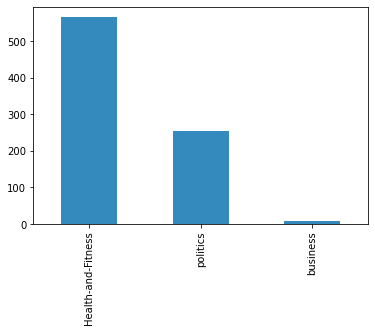

In [538]:
# https://www.ahmedbesbes.com/blog/interactive-topic-mining
df = pd.read_csv("cleaned-scraping-data.csv")

print('Number of Categories: ',df.groupby('category').ngroups)

# how many articles per category
print(df['category'].value_counts())

df.category.value_counts().plot(kind='bar', color='#348ABD')

Let's now check the disctribution of the content' lengths.



<AxesSubplot:>

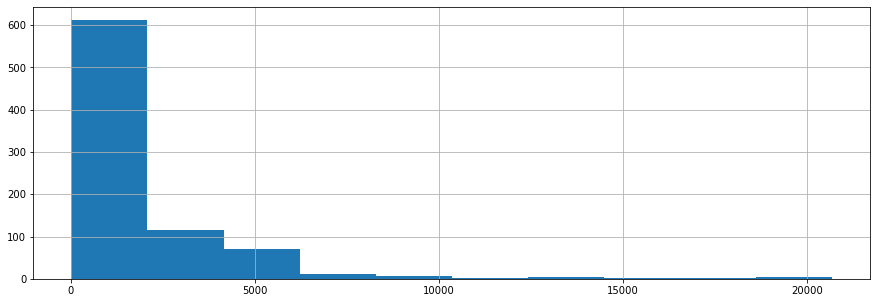

In [539]:
df.content.map(len).hist(figsize=(15, 5))

most frequent terms in content: 


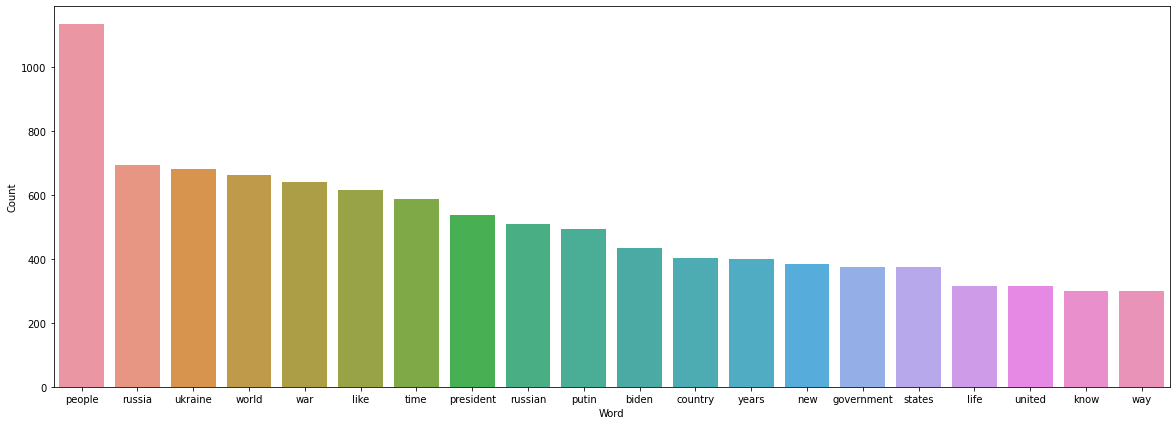

most frequent terms in topic: 


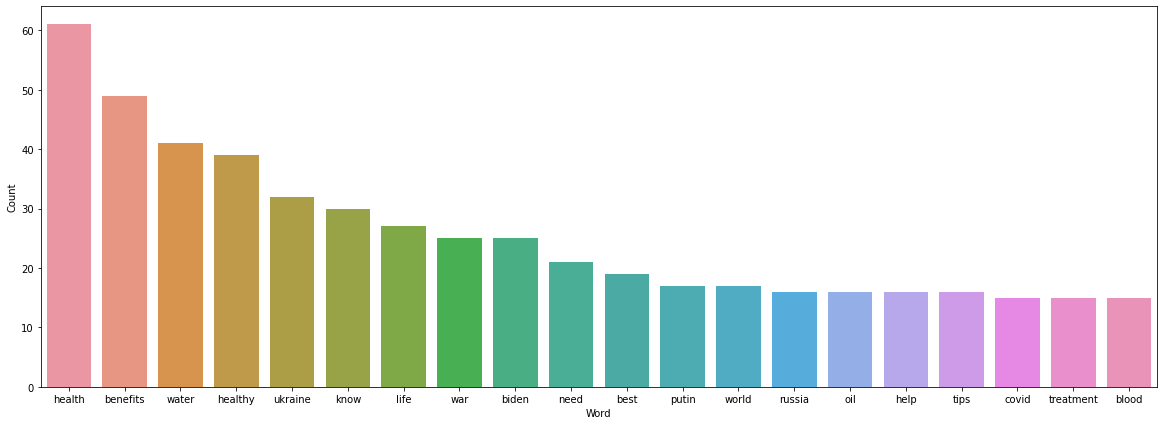

In [540]:
from nltk import FreqDist
# https://www.kaggle.com/code/simranjain17/web-scraping-news-articles-topic-modeling-nlp

# function to plot most frequent terms
def freq_words(x, terms = 20):
    all_words = ' '.join([content for content in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'Word':list(fdist.keys()), 'Count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="Count", n = terms) 
    plt.figure(figsize=(20,7))
    ax = sns.barplot(data=d, x= "Word", y = "Count")
    plt.show()

print("most frequent terms in content: ")
freq_words(df["content"])

print("most frequent terms in topic: ")
freq_words(df["topic"])

Word Cloud of content: 


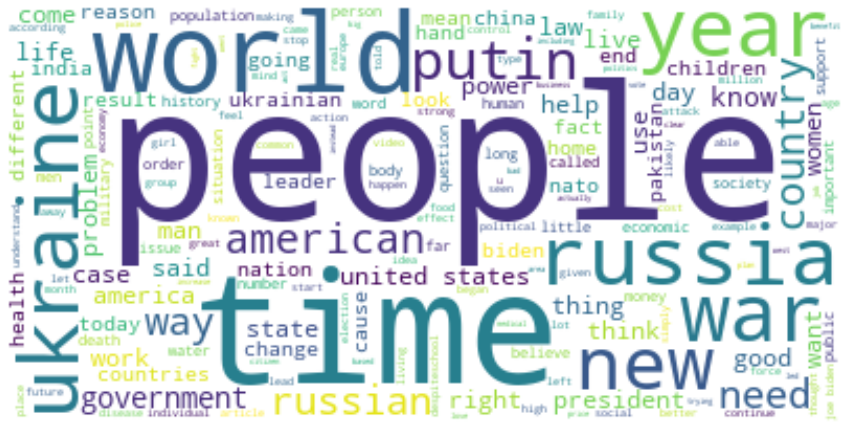

Word Cloud of topic: 


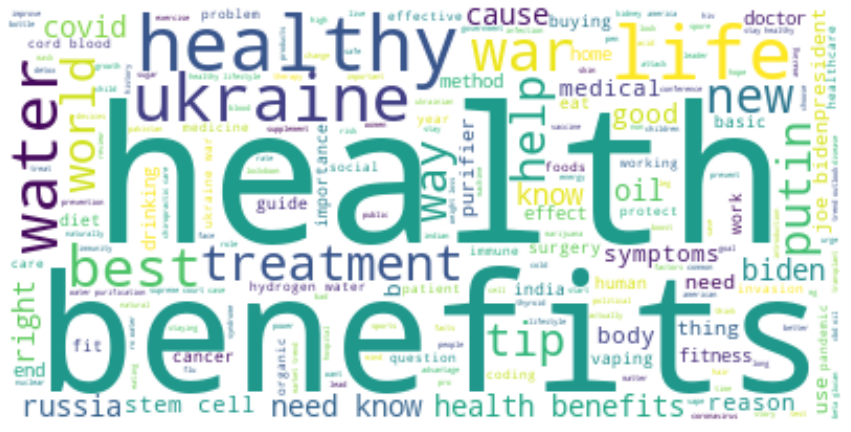

In [541]:
def wordCloud_content():
    text = " ".join(i for i in df.content)
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.figure( figsize=(15,13))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def wordCloud_topic():
    text = " ".join(i for i in df.topic)
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.figure( figsize=(15,13))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

print("Word Cloud of content: ")
wordCloud_content()

print("Word Cloud of topic: ")
wordCloud_topic()

# Tokenization

Tokenization is the process of breaking down a stream of text into words.
The main goal of this step is to extract individual words in a sentence.

Along with text classifcation, in text mining, it is necessay to incorporate
a parser in the pipeline which performs the tokenization of the documents

In [542]:
def tokenizer(text):
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

PyLDAvis allows us to interpret the topics in a topic model like below:

Let’s use pyLDAvis to visualize the topics:

- Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.
- Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
- Red bars give the estimated number of times a given term was generated by a given topic. As you can see from the image below, there are about 22,000 of the word ‘go’, and this term is used about 10,000 times within topic 1. The word with the longest red bar is the word that is used the most by the tweets belonging to that topic.


For more detailes about this model - https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know

In [543]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def get_data_from_csv(url):
    return pd.read_csv(url)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt

def tokenizer(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

tokens = list(tokenizer(df["content"]))


# Create Dictionary
id2word = corpora.Dictionary(tokens)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tokens]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.
# print_topics() as shown next.
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 3), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 3), (62, 1), (63, 2), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 4), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 2), (105, 2), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

C:\Users\Ori\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.316395  0.283321       1        1  39.073203
18     0.254566 -0.110318       2        1  21.069323
8      0.268691 -0.176202       3        1  18.394386
2      0.092111 -0.110764       4        1   6.953218
9      0.047562  0.021291       5        1   6.202366
5     -0.039731  0.047364       6        1   2.886818
14    -0.080614  0.014723       7        1   1.759394
12    -0.073148 -0.008556       8        1   0.935664
7     -0.076009  0.003969       9        1   0.841479
13    -0.079176  0.002398      10        1   0.617277
19    -0.077364  0.004127      11        1   0.365549
16    -0.070086  0.003109      12        1   0.299506
3     -0.069277  0.004102      13        1   0.264324
1     -0.068501  0.003189      14        1   0.230209
15    -0.058733  0.003087      15        1   0.033842
11    -0.058274  0.003058      16        1   0.033094
6     -0.057348  0.003066      17        1   0.016057
4     -0.057359  0.003024      18        1   0.011446
10    -0.056854  0.003006      19        1   0.006509
0     -0.056854  0.003006      20        1   0.006336, topic_info=            Term       Freq       Total Category  logprob  loglift
1579      russia  700.00000  700.000000  Default  30.0000  30.0000
1614     ukraine  689.00000  689.000000  Default  29.0000  29.0000
873        blood  377.00000  377.000000  Default  28.0000  28.0000
1206         war  614.00000  614.000000  Default  27.0000  27.0000
1580     russian  500.00000  500.000000  Default  26.0000  26.0000
...          ...        ...         ...      ...      ...      ...
25        change    0.00052  148.953301  Topic20  -9.8743  -2.8987
26      children    0.00052  189.187940  Topic20  -9.8743  -3.1378
27       choices    0.00052   23.793538  Topic20  -9.8743  -1.0644
28       circles    0.00052    9.515263  Topic20  -9.8743  -0.1479
29    colleagues    0.00052    7.188607  Topic20  -9.8743   0.1325

[947 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
7562      13  0.548621   abolished
5931       9  0.831040    accessed
3238      11  0.476622  accidental
0          1  0.882585  accomplish
1          1  0.590332   according
...      ...       ...         ...
8467      11  0.453549      yellow
369        1  0.035822       young
369        2  0.922410       young
369        5  0.035822       young
11798      4  0.973307        yuan

[942 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 19, 9, 3, 10, 6, 15, 13, 8, 14, 20, 17, 4, 2, 16, 12, 7, 5, 11, 1])

## Create and Fit Bag of Words Model
 
For more information - https://www.analyticsvidhya.com/blog/2021/12/text-classification-of-news-articles/

In this step, we construct a vector, which would tell us whether a word in each sentence is a frequent word or not. If a word in a sentence is a frequent word, we set it as 1, else we set it as 0.

Whenever we apply any algorithm in NLP, it works on numbers. We cannot directly feed our text into that algorithm. Hence, the Bag of Words model is used to preprocess the text by converting it into a bag of words, which keeps a count of the total occurrences of the most frequently used words.

In [544]:
from sklearn.feature_extraction.text import CountVectorizer
x = np.array(df.iloc[:,0].values)
y = np.array(df.category.values)
cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(df.content).toarray()
print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (828, 5000)
y.shape =  (828,)


## Train Test and Split the Dataset

We need to split a dataset into train and test sets to evaluate how well our machine learning model performs. The train set is used to fit the model, the statistics of the train set are known. The second set is called the test data set, this set is solely used for predictions.

In [545]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print("Length of train set: " + str(len(x_train)))
print("Length of test set: " + str(len(x_test)))

Length of train set: 579
Length of test set: 249


## Create, Fit and Predict all ML Model

In [550]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

#create list of model and accuracy dicts
perform_list = [ ]

def run_model(model_name, est_c, est_pnlty):
    
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()
   

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')
    print("")
    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [ ]:
# Logistic Regression  
run_model('Logistic Regression', est_c=None, est_pnlty=None)

# Random Forest
run_model('Random Forest', est_c=None, est_pnlty=None)

# Multinomial Naive Bayes
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

# Support Vector Machine
run_model('Support Vector Classifer', est_c=None, est_pnlty=None)

# Decision Tree
run_model('Decision Tree Classifier', est_c=None, est_pnlty=None)

# KNN
run_model('K Nearest Neighbour', est_c=None, est_pnlty=None)

# Gaussian Naive Bayes
run_model('Gaussian Naive Bayes', est_c=None, est_pnlty=None)


Test Accuracy Score of Basic Logistic Regression: % 96.79
Precision : 0.9678714859437751
Recall    : 0.9678714859437751
F1-score   : 0.9678714859437751

Test Accuracy Score of Basic Random Forest: % 96.79
Precision : 0.9678714859437751
Recall    : 0.9678714859437751
F1-score   : 0.9678714859437751

Test Accuracy Score of Basic Multinomial Naive Bayes: % 92.77
Precision : 0.927710843373494
Recall    : 0.927710843373494
F1-score   : 0.927710843373494

Test Accuracy Score of Basic Support Vector Classifer: % 98.39
Precision : 0.9839357429718876
Recall    : 0.9839357429718876
F1-score   : 0.9839357429718876

Test Accuracy Score of Basic Decision Tree Classifier: % 93.17
Precision : 0.9317269076305221
Recall    : 0.9317269076305221
F1-score   : 0.9317269076305221



Create Dataframe of Model, Accuracy, Precision, Recall, and F1

In [548]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,96.79,0.97,0.97,0.97
1,Random Forest,96.79,0.97,0.97,0.97
2,Multinomial Naive Bayes,92.77,0.93,0.93,0.93
3,Support Vector Classifer,98.39,0.98,0.98,0.98
4,Decision Tree Classifier,93.17,0.93,0.93,0.93
5,K Nearest Neighbour,86.75,0.87,0.87,0.87
6,Gaussian Naive Bayes,55.42,0.55,0.55,0.55


## Best model to perform accuracy score

In [549]:
model = model_performance["Model"]
max_value = model_performance["Test Accuracy"].max()
print("The best accuracy of model is", max_value,"from Logistic Regression")

The best accuracy of model is 98.39 from Logistic Regression
